# Recommender System with Collaborative Filtering

First, we need to read the data from the dataset.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# datasets_loc = "datasets"
datasets_loc = "toy_datasets"

In [3]:
ratings = pd.read_csv(datasets_loc + "/ratings.csv", delim_whitespace=True, skiprows=1, names=["UserID", "ProfileID", "Rating"])
# gender = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender"]) (For large dataset)
info = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender", "Name"])

Here is our data. UserID is the user, ProfileID is the profile that user is looking at.

In [4]:
ratings.head()

,UserID,ProfileID,Rating
0,3,1,1
1,3,2,5
2,3,5,10
3,4,1,10
4,4,5,6


In [5]:
info.head()

,UserID,Gender,Name
0,1,F,Anna
1,2,F,Sarah
2,3,M,Bob
3,4,M,Peter
4,5,F,Mary


In [6]:
ratings = pd.merge(info, ratings)
ratings

,UserID,Gender,Name,ProfileID,Rating
0,3,M,Bob,1,1
1,3,M,Bob,2,5
2,3,M,Bob,5,10
3,4,M,Peter,1,10
4,4,M,Peter,5,6
5,6,M,Tom,1,10
6,6,M,Tom,2,10
7,6,M,Tom,5,0
8,6,M,Tom,8,9
9,7,M,Jack,1,10


We map the rating to like/ dislike. Rating smaller than 5 will consider as a dislike to the profile.

In [7]:
ratings["Rating"] = np.where(ratings["Rating"] < 5, 0, 1)
ratings = ratings[ratings["Rating"] == 1]
ratings

,UserID,Gender,Name,ProfileID,Rating
1,3,M,Bob,2,1
2,3,M,Bob,5,1
3,4,M,Peter,1,1
4,4,M,Peter,5,1
5,6,M,Tom,1,1
6,6,M,Tom,2,1
8,6,M,Tom,8,1
9,7,M,Jack,1,1
10,7,M,Jack,2,1
11,7,M,Jack,5,1


Due to large data set, we need to reduce the data records.

In [8]:
ratings = ratings[(ratings["UserID"] <= 10000) & (ratings["ProfileID"] <= 10000)]
ratings

,UserID,Gender,Name,ProfileID,Rating
1,3,M,Bob,2,1
2,3,M,Bob,5,1
3,4,M,Peter,1,1
4,4,M,Peter,5,1
5,6,M,Tom,1,1
6,6,M,Tom,2,1
8,6,M,Tom,8,1
9,7,M,Jack,1,1
10,7,M,Jack,2,1
11,7,M,Jack,5,1


# Preparing data for Collaborative Filtering  

In [9]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

Data here only contains the user likes. Dislike rating and no rating will be considered as NaN.

In [10]:
user_ratings = ratings.pivot_table(index=["UserID"], columns=["ProfileID"], values=["Rating"])
user_ratings.head()

Rating                         
ProfileID     1    2    5    8    10   11
UserID                                   
3            NaN  1.0  1.0  NaN  NaN  NaN
4            1.0  NaN  1.0  NaN  NaN  NaN
6            1.0  1.0  NaN  1.0  NaN  NaN
7            1.0  1.0  1.0  NaN  1.0  NaN
9            NaN  1.0  NaN  1.0  NaN  1.0

So here, we fill all NaN to 0. Assuming if user did not vote -> dislike.
Which is not ideal.

In [11]:
user_ratings = user_ratings.fillna(0)
user_ratings

Rating                         
ProfileID     1    2    5    8    10   11
UserID                                   
3            0.0  1.0  1.0  0.0  0.0  0.0
4            1.0  0.0  1.0  0.0  0.0  0.0
6            1.0  1.0  0.0  1.0  0.0  0.0
7            1.0  1.0  1.0  0.0  1.0  0.0
9            0.0  1.0  0.0  1.0  0.0  1.0

In [12]:
# Clear pivot table structure to extra index and columns

user_ratings_df = user_ratings.copy()

user_ratings_df.columns = user_ratings.columns.droplevel(0)
user_ratings_df.name = None
user_ratings_df = user_ratings_df.reset_index()
user_ratings_df.index = user_ratings_df["UserID"]
user_ratings_df.index.name = "UserID"
user_ratings_df.drop("UserID", axis="columns", inplace=True)

user_ratings_df

ProfileID,1,2,5,8,10,11
UserID,,,,,,
3,0.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0
6,1.0,1.0,0.0,1.0,0.0,0.0
7,1.0,1.0,1.0,0.0,1.0,0.0
9,0.0,1.0,0.0,1.0,0.0,1.0


# Item-based Collaborative Filtering
With KNN algorithm, we can find the similar profiles to the profile that user is looking at. 

In [13]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(user_ratings_df.T)

# Here, skipped the cosine similarity matrix

# Same dataset (traning and testing), so nearest is itself (For now)
distances, indices = knn.kneighbors(user_ratings_df.T.values, n_neighbors=3)

In [14]:
# Predict like/ dislike for a Profile by a User

def findNearestProfiles(profile_id):
    # Get the index for a profile
    index_of_profile = user_ratings_df.T.index.tolist().index(profile_id)

    # Find the indices for similar profiles
    sim_profiles = indices[index_of_profile].tolist()

    # Find the distances between the profile and similar profiles
    sim_profiles_distances = distances[index_of_profile].tolist()

    # The position of the profile in the list of similar profiles
    index_of_profile_in_sim = sim_profiles.index(index_of_profile)

    # Remove the profile from the list of similar profiles
    sim_profiles.pop(index_of_profile_in_sim)

    # Remove the profile from the list of similar profiles
    sim_profiles_distances.pop(index_of_profile_in_sim)

    print("The nearest profiles to Profile {} are:".format(profile_id), ["Profile {}".format(user_ratings_df.columns[i]) for i in sim_profiles])
    print("The distance from Profile {}:".format(profile_id), sim_profiles_distances)
    print("Returned", sim_profiles, sim_profiles_distances)
    return sim_profiles, sim_profiles_distances

findNearestProfiles(1)

The nearest profiles to Profile 1 are: ['Profile 5', 'Profile 2']
The distance from Profile 1: [0.33333333333333315, 0.42264973081037416]
Returned [2, 1] [0.33333333333333315, 0.42264973081037416]


([2, 1], [0.33333333333333315, 0.42264973081037416])

In [37]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the profile
    profile_ratings = user_ratings_df.T.iloc[index_of_profile].values.tolist()

    # Find the nearest neighbors of the profile
    sim_profiles, sim_profiles_distances = findNearestProfiles(profile_id)
    
    # Get the ratings for the similar profiles
    sim_profiles_ratings = [user_ratings_df.T.iloc[i].values.tolist() for i in sim_profiles]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_profiles_distances[i] * (sim_profiles_ratings[i][index_of_user] - average(user_ratings_df.T.iloc[sim_profiles[i]].values.tolist())) for i in range(len(sim_profiles))])
    denominator = sum(sim_profiles_distances)

    predicted_rating = average(profile_ratings) + numerator / denominator 

    print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

predict_rating_with_neighbor_correlations(3, 11)

The nearest profiles to Profile 11 are: ['Profile 8', 'Profile 2']
The distance from Profile 11: [0.29289321881345254, 0.5]
Returned [3, 1] [0.29289321881345254, 0.5]
The predicted rating for User 3 and Profile 11 is: 0.17836116248912237


0.17836116248912237

In [40]:
# Recommender system for a user
predicted_ratings = user_ratings_df.T.copy()

def recommender_system_item_based_CF(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        if user_ratings_df.T.loc[profile_id, user_id] == 0:
            predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
            recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [41]:
# Output recommendations
user_id = 3

recommendations = recommender_system_item_based_CF(user_id)
pd.DataFrame(predicted_ratings)

The nearest profiles to Profile 1 are: ['Profile 5', 'Profile 2']
The distance from Profile 1: [0.33333333333333315, 0.42264973081037416]
Returned [2, 1] [0.33333333333333315, 0.42264973081037416]
The predicted rating for User 3 and Profile 1 is: 0.888185397039521
The nearest profiles to Profile 8 are: ['Profile 2', 'Profile 11']
The distance from Profile 8: [0.29289321881345254, 0.29289321881345254]
Returned [1, 5] [0.29289321881345254, 0.29289321881345254]
The predicted rating for User 3 and Profile 8 is: 0.4
The nearest profiles to Profile 10 are: ['Profile 5', 'Profile 1']
The distance from Profile 10: [0.42264973081037416, 0.42264973081037416]
Returned [2, 0] [0.42264973081037416, 0.42264973081037416]
The predicted rating for User 3 and Profile 10 is: 0.10000000000000006
The nearest profiles to Profile 11 are: ['Profile 8', 'Profile 2']
The distance from Profile 11: [0.29289321881345254, 0.5]
Returned [3, 1] [0.29289321881345254, 0.5]
The predicted rating for User 3 and Profile 11

UserID,3,4,6,7,9
ProfileID,,,,,
1,0.888185,1.0,1.0,1.0,0.0
2,1.000000,0.0,1.0,1.0,1.0
5,1.000000,1.0,0.0,1.0,0.0
8,0.400000,0.0,1.0,0.0,1.0
10,0.100000,0.0,0.0,1.0,0.0
11,0.178361,0.0,0.0,0.0,1.0


In [42]:
print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

for profile_id, predicted_rating in recommendations:
    print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User Bob:
('Anna', 0.888185397039521)
('Amy', 0.4)
('Helen', 0.10000000000000006)
('Emma', 0.17836116248912237)


# Visualize the network graph

Using the non pivot version (ratings) to visualize.

## For small dataset visualization

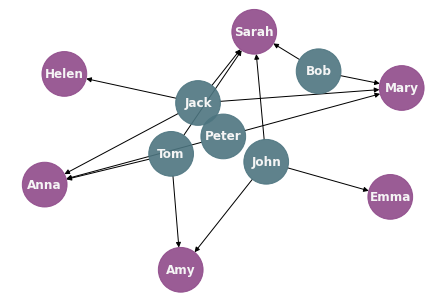

In [85]:
# Remarks: This won't plot node without positive rating associated with it.
# As negative rating has been remove before

import matplotlib.pyplot as plt
import networkx as nx

gr = nx.from_pandas_edgelist(ratings, "UserID", "ProfileID", "Rating", create_using=nx.DiGraph())

mapping = dict(info[["UserID", "Name"]].values.tolist())
color_map = []
for node in gr.nodes():
    if info.loc[info["UserID"] == node, "Gender"].values[0] == "M":
        color_map.append([0.3, 0.46, 0.5, 0.9])
    else:
        color_map.append([0.56, 0.29, 0.54, 0.9])

gr = nx.relabel_nodes(gr, mapping)
pos = nx.fruchterman_reingold_layout(gr)
nx.draw(gr, pos, with_labels=True, node_size=2000, node_color=color_map, font_color="whitesmoke", font_weight="semibold")
plt.show()

## For large dataset visualization

In [99]:
# Only execute this with large dataset

import graph_tool.all as gt 
import random
from IPython.display import Image

network_graph_file = "network-graph-" + str(random.randint(0, 2e9)) + ".png"

g = gt.Graph(directed=True)
vmap = g.add_edge_list(ratings[["UserID", "ProfileID"]].to_numpy(), hashed=True)
pos = gt.fruchterman_reingold_layout(g, n_iter=10)

v_size = g.new_vertex_property("double")
g.vertex_properties["v_size"] = v_size

v_font_size = g.new_vertex_property("double")
g.vertex_properties["v_font_size"] = v_font_size

v_pen_width = g.new_vertex_property("double")
g.vertex_properties["v_pen_width"] = v_pen_width
 
for v in g.vertices():
    v_size[v] = (1 + v.in_degree() * 4) * (1000 / g.num_vertices())
    v_font_size[v] = (1 + v.in_degree()) * (400 / g.num_vertices())
    v_pen_width[v] = (1 + v.in_degree()) * (100 / g.num_vertices())

gt.graph_draw(g, vertex_text=vmap, pos=pos, vertex_size=v_size, vertex_font_size=v_font_size, vertex_fill_color=[0.2, 0.4, 0.53, 0.9], vertex_pen_width=v_pen_width, vertex_font_family="roboto", output_size=(2048, 2048), bg_color=[1, 1, 1, 1], output=network_graph_file)

Image(url=network_graph_file)

# Below are the cells that I haven't finished yet.

In [69]:
# def standardize(row):
#     new_row = (row - row.mean()) / (row.max() - row.min())
#     return new_row

# user_ratings_std = user_ratings.apply(standardize)
# user_ratings_std

In [32]:
# Profile-Profile Similarity with Cosine similarity

def calculate_similarity(data):
    similarity = cosine_similarity(data)
    return similarity

profile_similarity = calculate_similarity(user_ratings.T)
profile_similarity_df = pd.DataFrame(profile_similarity, index=user_ratings_df.columns.values, columns=user_ratings_df.columns.values)
profile_similarity_df

,1,2,5
1,1.000000,0.000000,0.707107
2,0.000000,1.000000,0.707107
5,0.707107,0.707107,1.000000


In [34]:
# Making recommendations

def get_similar_profile(profile_id, user_rating):
    similar_score = profile_similarity_df[profile_id] * user_rating
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

result = get_similar_profile(1, 1)
result


1    1.000000
5    0.707107
2    0.000000
Name: 1, dtype: float64